In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, \
average_precision_score, roc_auc_score, plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix 
from sklearn.exceptions import ConvergenceWarning

from xgboost import XGBClassifier, XGBRFClassifier, plot_importance

from imblearn.over_sampling import SMOTENC

import matplotlib.pyplot as plt

import warnings

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from IPython.display import clear_output


import pickle

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.functions import add_model, test_model, get_timeseries_table

from seaborn import heatmap

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [12]:
def return_score(optim_result):
    score = opt.best_score_
    params = opt.best_params_
    clear_output()
    print('Best Score So Far: ', score)
    print('Using Parameters: ', params)

In [13]:
prediction_window = 135

df = get_timeseries_table(prediction_window=prediction_window,
                         binary_labels=True, one_hot_modules=True)

X = df.drop(columns=['final_result'])
y = df['final_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=111)

assessments merged:  1


In [14]:
all_features='activities, clicks, assessments, modules'

In [15]:
models = [LogisticRegression(random_state=111, solver='liblinear'),
         DecisionTreeClassifier(random_state=111),
         RandomForestClassifier(random_state=111),
#          CategoricalNB(),
#          GaussianNB(),
         KNeighborsClassifier(),
         SVC(random_state=111),
         AdaBoostClassifier(random_state=111),
         XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=111)      
         ]

for model in models:
    add_model(model, X_t, y_t, X_val, y_val, features=all_features, load=True, save=True)

pd.read_csv('hyper_parameter_table.csv')

,model,preprocessing,features,regularization,regularization_strength,class_imbalance,train_accuracy,val_accuracy,train_f1_score,val_f1_score
0,XGBClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.972078,0.841369,0.960420,0.761841
1,AdaBoostClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.831506,0.823595,0.744353,0.738127
2,XGBClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,0.979410,0.818263,0.970681,0.722524
3,RandomForestClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.999926,0.825594,0.999896,0.705882
4,AdaBoostClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,0.819879,0.809154,0.717734,0.704506
5,DecisionTreeClassifier,None,"activities, clicks, assessments, modules",None,None,None,1.000000,0.760498,1.000000,0.675105
6,RandomForestClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,1.000000,0.805821,1.000000,0.666667
7,LogisticRegression,normalized,"activities, clicks, assessments, modules",l2,1.0,None,0.777218,0.776716,0.652816,0.652610
8,LogisticRegression,None,"activities, clicks, assessments, modules",l2,1.0,None,0.798919,0.784937,0.654888,0.639881
9,SVC,None,"activities, clicks, assessments, modules",None,None,None,0.813435,0.780049,0.699940,0.638158


In [18]:
X_t_normal = normalize(X_t)
X_val_normal = normalize(X_val)
X_train_normal = normalize(X_train)
X_test_normal = normalize(X_test)

models = [LogisticRegression(random_state=111, solver='liblinear'),
         DecisionTreeClassifier(random_state=111),
         RandomForestClassifier(random_state=111),
         CategoricalNB(),
         GaussianNB(),
         KNeighborsClassifier(),
         SVC(random_state=111),
         AdaBoostClassifier(random_state=111),
         XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=111)      
         ]

for model in models:
    add_model(model, X_t_normal, y_t, X_val_normal, y_val, features=all_features, 
              load=True, save=True,
              preprocessing='normalized')

pd.read_csv('hyper_parameter_table.csv')

,model,preprocessing,features,regularization,regularization_strength,class_imbalance,train_accuracy,val_accuracy,train_f1_score,val_f1_score
0,XGBClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.972078,0.841369,0.960420,0.761841
1,AdaBoostClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.831506,0.823595,0.744353,0.738127
2,XGBClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,0.979410,0.818263,0.970681,0.722524
3,RandomForestClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.999926,0.825594,0.999896,0.705882
4,AdaBoostClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,0.819879,0.809154,0.717734,0.704506
5,DecisionTreeClassifier,None,"activities, clicks, assessments, modules",None,None,None,1.000000,0.760498,1.000000,0.675105
6,RandomForestClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,1.000000,0.805821,1.000000,0.666667
7,LogisticRegression,normalized,"activities, clicks, assessments, modules",l2,1.0,None,0.777218,0.776716,0.652816,0.652610
8,LogisticRegression,None,"activities, clicks, assessments, modules",l2,1.0,None,0.798919,0.784937,0.654888,0.639881
9,SVC,None,"activities, clicks, assessments, modules",None,None,None,0.813435,0.780049,0.699940,0.638158


h_table = None

In [19]:
xgb = XGBClassifier(use_label_encoder=False, seed=111, eval_metric='logloss')

xgb_search_space = {'objective': Categorical(['binary:logistic',
                                              'binary:hinge',
                                              'binary:logitraw']),
                    'eval_metric': Categorical(['logloss','error']),
                   'learning_rate': Real(0.05, .3, 'log-uniform'),
                   'min_child_weight': Integer(1,10, 'uniform'),
                   'max_depth': Integer(3,30, 'normal'),
                   'subsample': Real(0.3, 1, 'normal'),
                   'colsample_bytree': Real(.3, 1.0, 'normal'),
                   'scale_pos_weight': Real(.5, 2.0, 'uniform')}

opt = BayesSearchCV(xgb, search_spaces=xgb_search_space, 
                    n_iter=50, cv=2,
                    n_jobs=4,
                    pre_dispatch = 8,
                    random_state=111,
                    return_train_score=True)

opt.fit(X_t, y_t, callback=return_score)

XGBclf = opt.best_estimator_

params = XGBclf.get_params()
regularization=f"{('subsample', params['subsample']),('min_child_weight', params['min_child_weight'])}"
regularization = regularization + f"{('max_depth', params['max_depth']),('colsample_bytree', params['colsample_bytree'])}",
add_model(XGBclf, X_t, y_t, X_val, y_val, features=all_features, preprocessing=None, 
          save=True, load=True,
          regularization=regularization,
         class_imbalance=f'scale_pos_weight: {params["scale_pos_weight"]}')

Best Score So Far:  0.8398755739890387
Using Parameters:  OrderedDict([('colsample_bytree', 0.7675904063530627), ('eval_metric', 'error'), ('learning_rate', 0.05223962391018215), ('max_depth', 28), ('min_child_weight', 10), ('objective', 'binary:logistic'), ('scale_pos_weight', 0.7494602288710461), ('subsample', 1.0)])


,model,preprocessing,features,regularization,regularization_strength,class_imbalance,train_accuracy,val_accuracy,train_f1_score,val_f1_score
0,XGBClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.972078,0.841369,0.960420,0.761841
1,XGBClassifier,None,"activities, clicks, assessments, modules","((('subsample', 1.0), ('min_child_weight', 10)...",None,scale_pos_weight: 0.7494602288710461,0.925122,0.845590,0.885413,0.758597
2,AdaBoostClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.831506,0.823595,0.744353,0.738127
3,XGBClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,0.979410,0.818263,0.970681,0.722524
4,RandomForestClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.999926,0.825594,0.999896,0.705882
5,AdaBoostClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,0.819879,0.809154,0.717734,0.704506
6,DecisionTreeClassifier,None,"activities, clicks, assessments, modules",None,None,None,1.000000,0.760498,1.000000,0.675105
7,RandomForestClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,1.000000,0.805821,1.000000,0.666667
8,LogisticRegression,normalized,"activities, clicks, assessments, modules",l2,1.0,None,0.777218,0.776716,0.652816,0.652610
9,LogisticRegression,None,"activities, clicks, assessments, modules",l2,1.0,None,0.798919,0.784937,0.654888,0.639881


In [24]:
# rf = RandomForestClassifier(random_state=111)

# rf_search_space = {'n_estimators': Integer(50, 500, 'normal'),
#                    'max_depth': Integer(5, 50, 'normal'),
#                    'max_features': Categorical(['sqrt','log2',None]),
#                    'class_weight': Categorical(['balanced','balanced_subsample',None]),
#                    'max_samples': Real(.1, .99, 'uniform')
#                    }

# opt = BayesSearchCV(rf, search_spaces=rf_search_space, 
#                     n_iter=50, cv=2,
#                     n_jobs=4,
#                     pre_dispatch = 8,
#                     random_state=111,
#                     return_train_score=True)

# opt.fit(X_t, y_t, callback=return_score)

# RFclf = opt.best_estimator_

# params = RFclf.get_params()
regularization = f"{('max_depth', params['max_depth']),('max_features', params['max_features']), ('max_samples', params['max_samples'])}"
regularization = f"n_estimators: {params['n_estimators']}" + regularization 
add_model(RFclf, X_t, y_t, X_val, y_val, features=all_features, preprocessing=None,
          class_imbalance=f'class_weight: {params["class_weight"]}',
         regularization=regularization,
          save=True, load=True)

,model,preprocessing,features,regularization,regularization_strength,class_imbalance,train_accuracy,val_accuracy,train_f1_score,val_f1_score
0,XGBClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.972078,0.841369,0.960420,0.761841
1,XGBClassifier,None,"activities, clicks, assessments, modules","(""(('subsample', 1.0), ('min_child_weight', 10...",None,scale_pos_weight: 0.7494602288710461,0.925122,0.845590,0.885413,0.758597
2,RandomForestClassifier,None,"activities, clicks, assessments, modules","n_estimators: 500(('max_depth', 50), ('max_fea...",None,class_weight: None,0.936306,0.835592,0.904296,0.739437
3,AdaBoostClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.831506,0.823595,0.744353,0.738127
4,XGBClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,0.979410,0.818263,0.970681,0.722524
5,RandomForestClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.999926,0.825594,0.999896,0.705882
6,AdaBoostClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,0.819879,0.809154,0.717734,0.704506
7,DecisionTreeClassifier,None,"activities, clicks, assessments, modules",None,None,None,1.000000,0.760498,1.000000,0.675105
8,RandomForestClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,1.000000,0.805821,1.000000,0.666667
9,LogisticRegression,normalized,"activities, clicks, assessments, modules",l2,1.0,None,0.777218,0.776716,0.652816,0.652610


In [25]:
regularization


"n_estimators: 500(('max_depth', 50), ('max_features', None), ('max_samples', 0.3771357856777118))"

In [27]:
DT = DecisionTreeClassifier(random_state=111)

DT_search_space = {'criterion': Categorical(['gini','entropy']),
                   'splitter': Categorical(['best','random']),
                    'max_depth': Integer(3,10, 'uniform'),
                   'max_features': Categorical(['sqrt','log2', None]),
                   'class_weight': Categorical(['balanced',None]),
                   }

opt = BayesSearchCV(DT, search_spaces=DT_search_space, 
                    n_iter=50, cv=2,
                    n_jobs=4,
                    pre_dispatch = 8,
                    random_state=111,
                    return_train_score=True)

opt.fit(X_t, y_t, callback=return_score)

DTclf = opt.best_estimator_
DTclf

params = DTclf.get_params()
regularization=f"{('max_depth', params['max_depth']),('max_features', params['max_features'])}"

add_model(DTclf, X_t, y_t, X_val, y_val, features=all_features, preprocessing=None,
          class_imbalance=f'class_weight: {params["class_weight"]}',
          regularization=regularization,
          save=True, load=True)

Best Score So Far:  0.8098059546733817
Using Parameters:  OrderedDict([('class_weight', None), ('criterion', 'gini'), ('max_depth', 6), ('max_features', None), ('splitter', 'random')])


,model,preprocessing,features,regularization,regularization_strength,class_imbalance,train_accuracy,val_accuracy,train_f1_score,val_f1_score
0,XGBClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.972078,0.841369,0.960420,0.761841
1,XGBClassifier,None,"activities, clicks, assessments, modules","(""(('subsample', 1.0), ('min_child_weight', 10...",None,scale_pos_weight: 0.7494602288710461,0.925122,0.845590,0.885413,0.758597
2,RandomForestClassifier,None,"activities, clicks, assessments, modules","n_estimators: 500(('max_depth', 50), ('max_fea...",None,class_weight: None,0.936306,0.835592,0.904296,0.739437
3,AdaBoostClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.831506,0.823595,0.744353,0.738127
4,XGBClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,0.979410,0.818263,0.970681,0.722524
5,RandomForestClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.999926,0.825594,0.999896,0.705882
6,AdaBoostClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,0.819879,0.809154,0.717734,0.704506
7,DecisionTreeClassifier,None,"activities, clicks, assessments, modules","(('max_depth', 6), ('max_features', None))",None,class_weight: None,0.817212,0.810042,0.683021,0.676749
8,DecisionTreeClassifier,None,"activities, clicks, assessments, modules",None,None,None,1.000000,0.760498,1.000000,0.675105
9,RandomForestClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,1.000000,0.805821,1.000000,0.666667


In [28]:
table = pd.read_csv('hyper_parameter_table.csv')
display(table)

,model,preprocessing,features,regularization,regularization_strength,class_imbalance,train_accuracy,val_accuracy,train_f1_score,val_f1_score
0,XGBClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.972078,0.841369,0.960420,0.761841
1,XGBClassifier,None,"activities, clicks, assessments, modules","(""(('subsample', 1.0), ('min_child_weight', 10...",None,scale_pos_weight: 0.7494602288710461,0.925122,0.845590,0.885413,0.758597
2,RandomForestClassifier,None,"activities, clicks, assessments, modules","n_estimators: 500(('max_depth', 50), ('max_fea...",None,class_weight: None,0.936306,0.835592,0.904296,0.739437
3,AdaBoostClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.831506,0.823595,0.744353,0.738127
4,XGBClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,0.979410,0.818263,0.970681,0.722524
5,RandomForestClassifier,None,"activities, clicks, assessments, modules",None,None,None,0.999926,0.825594,0.999896,0.705882
6,AdaBoostClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,0.819879,0.809154,0.717734,0.704506
7,DecisionTreeClassifier,None,"activities, clicks, assessments, modules","(('max_depth', 6), ('max_features', None))",None,class_weight: None,0.817212,0.810042,0.683021,0.676749
8,DecisionTreeClassifier,None,"activities, clicks, assessments, modules",None,None,None,1.000000,0.760498,1.000000,0.675105
9,RandomForestClassifier,normalized,"activities, clicks, assessments, modules",None,None,None,1.000000,0.805821,1.000000,0.666667


In [29]:
clf=XGBclf

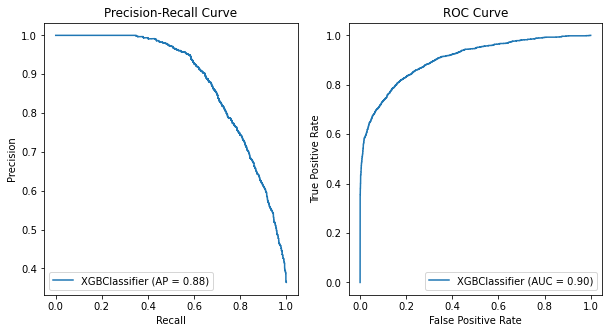

In [30]:
y_score = clf.predict_proba(X_val)[:,1]

fig, axes = plt.subplots(1,2, figsize=(10,5))
plot_precision_recall_curve(clf, X_val, y_val, ax = axes[0])
axes[0].set_title('Precision-Recall Curve')

plot_roc_curve(clf, X_val, y_val, ax= axes[1])
axes[1].set_title('ROC Curve')
plt.show()

In [31]:
thresh_accuracy = pd.DataFrame(columns= ['accuracy', 'f1_score'],
                              index = [x/100 for x in range(60,80)])

thresh_accuracy.index.name = 'Threshold'
for thresh in range(10, 90):
    thresh /= 100
    yhat = pd.Series(y_score).apply(lambda x: 1 if x >= thresh else 0)
    accuracy = accuracy_score(y_val, yhat)
    f1 = f1_score(y_val, yhat)
    roc = roc_auc_score(y_val, y_score)
    pr = average_precision_score(y_val, y_score)
    thresh_accuracy.loc[thresh, 'accuracy'] = accuracy
    thresh_accuracy.loc[thresh, 'f1_score'] = f1

print('ROC_AUC: ', roc)
print('PR_AUC: ', pr)
thresh_accuracy = thresh_accuracy.sort_values(by='f1_score', ascending=False)
thresh_accuracy.head(20)

ROC_AUC:  0.9045384236049729
PR_AUC:  0.8814932560845513


,accuracy,f1_score
Threshold,,
0.29,0.832704,0.773398
0.30,0.833593,0.772824
0.26,0.827372,0.772474
0.31,0.834481,0.771962
0.28,0.830038,0.77171
0.27,0.828705,0.771691
0.32,0.835592,0.771605
0.33,0.836703,0.771526
0.25,0.823817,0.770478


<AxesSubplot:>

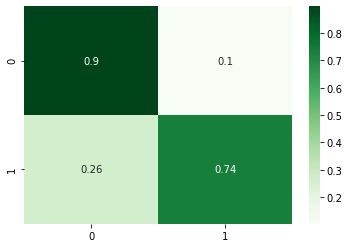

In [32]:
yhat = pd.Series(y_score)
best_thresh = thresh_accuracy.index[0]
yhat = yhat.apply(lambda x: 1 if x >= .37 else 0)

confusion  = confusion_matrix(y_val, yhat, normalize='true')
heatmap(confusion, annot=True, cmap='Greens')

In [34]:
importance = pd.DataFrame(XGBclf.feature_importances_, index=X_t.columns)
importance.sort_values(by=0, ascending=False).head(20)

,0
assess_score_2,0.018089
module_CCC,0.015206
module_GGG,0.014393
assess_score_3,0.010560
sum_activities_117,0.010325
sum_activities_130,0.007409
sum_activities_131,0.007274
sum_click_123,0.006777
sum_activities_134,0.006763
sum_activities_122,0.006310


In [35]:
categoricals = [502, 501, 500, 499, 498, 497, 496]
smotenc = SMOTENC(categoricals, random_state=111)
os_X_train, os_y_train = smotenc.fit_resample(X_train, y_train)
os_X_t, os_y_t = smotenc.fit_resample(X_t, y_t)

In [36]:
clf.fit(os_X_t, os_y_t, eval_metric='logloss')
y_score = clf.predict_proba(X_val)[:,1]

thresh_accuracy = pd.DataFrame(columns= ['accuracy', 'f1_score'],
                              index = [x/100 for x in range(60,80)])
thresh_accuracy.index.name = 'Threshold'

for thresh in range(10, 90):
    thresh /= 100
    yhat = pd.Series(y_score).apply(lambda x: 1 if x >= thresh else 0)
    accuracy = accuracy_score(y_val, yhat)
    f1 = f1_score(y_val, yhat)
    roc = roc_auc_score(y_val, y_score)
    pr = average_precision_score(y_val, y_score)
    thresh_accuracy.loc[thresh, 'accuracy'] = accuracy
    thresh_accuracy.loc[thresh, 'f1_score'] = f1

print('ROC_AUC: ', roc)
print('PR_AUC: ', pr)
thresh_accuracy = thresh_accuracy.sort_values(by='f1_score', ascending=False)
thresh_accuracy.head(5)

ROC_AUC:  0.9052070997839761
PR_AUC:  0.8821642196440669


,accuracy,f1_score
Threshold,,
0.36,0.842035,0.782502
0.35,0.841146,0.782079
0.33,0.837592,0.780546
0.34,0.838703,0.780133
0.31,0.834703,0.779621


<AxesSubplot:>

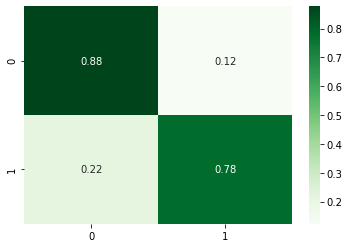

In [37]:
best_thresh = thresh_accuracy.index[0]

yhat = [1 if x >= best_thresh else 0 for x in y_score]

confusion  = confusion_matrix(y_val, yhat, normalize='true')
heatmap(confusion, annot=True, cmap='Greens')

In [38]:
import pickle
pickle.dump(clf, open('time_series_xgb_best.pkl','wb'))